In [1]:
# Install necessary packages
!pip install tensorflow==2.9.1
!pip install keras==2.9.0
!pip install pillow
!pip install nltk
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 32.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstalled flatbuffers-24.3.25
  Attempting uninstall: tensorboard-data-serve

In [4]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle
import nltk
import glob
import pandas as pd
import cv2
import zipfile
from google.colab import drive

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
drive.mount('/content/drive')

# Path to dataset in Google Drive
dataset_path = '/content/drive/MyDrive/flick.zip'

# Extract dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
  zip_ref.extractall('/content/flickr8k')

Mounted at /content/drive


In [11]:
# Read and print the first 5 lines of the captions file
with open(captions_path, 'r') as file:
    lines = file.readlines()
    print(f'Total lines in captions file: {len(lines)}')
    print('First 5 lines:')
    for line in lines[:5]:
        print(line.strip())


Total lines in captions file: 40456
First 5 lines:
image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .


In [14]:
# Set the path for images and captions
images_path = 'flickr8k/Images'
captions_path = 'flickr8k/captions.txt'
# Load the captions file
captions = open(captions_path, 'r').read()
# Create a dictionary to map image IDs to captions

def load_descriptions(doc):
    mapping = {}
    for line in doc.strip().split('\n'):
        tokens = line.strip().split(',', 1)  # Split on first comma
        if len(tokens) < 2:
            continue
        image_id, caption = tokens[0], tokens[1]
        # Remove the file extension from image_id
        image_id = image_id.split('.')[0]
        caption = caption.lower()
        # Store the caption in the mapping
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)
    return mapping
descriptions = load_descriptions(captions)
print('Loaded:', len(descriptions), 'descriptions')


Loaded: 5113 descriptions


In [15]:
import string

def clean_descriptions(descriptions):
    # Prepare a translation table to remove punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # Tokenize
            desc = desc.split()
            # Convert to lower case and remove punctuation
            desc = [word.lower().translate(table) for word in desc]
            # Remove non-alphabetic tokens and single-character tokens
            desc = [word for word in desc if word.isalpha() and len(word) > 1]
            # Store the cleaned caption back
            desc_list[i] = ' '.join(desc)

clean_descriptions(descriptions)


In [16]:
def add_start_end_tokens(descriptions):
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc_list[i] = 'startseq ' + desc_list[i] + ' endseq'

add_start_end_tokens(descriptions)


In [17]:
# Build vocabulary
word_counts = {}
for key in descriptions.keys():
    for desc in descriptions[key]:
        words = desc.split()
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1

# Remove words that occur less than threshold times
threshold = 10
vocab = [word for word in word_counts if word_counts[word] >= threshold]
print('Filtered Vocabulary Size:', len(vocab))


Filtered Vocabulary Size: 1520


In [18]:
# Create word-to-index and index-to-word mappings
ixtoword = {}
wordtoix = {}
ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

# Store the size of vocabulary
vocab_size = len(wordtoix) + 1  # Adding 1 for padding (0 index)
print('Vocabulary Size:', vocab_size)


Vocabulary Size: 1521


In [19]:
# Find maximum length of any caption
max_length = max(len(desc.split()) for key in descriptions.keys() for desc in descriptions[key])
print('Maximum Caption Length:', max_length)


Maximum Caption Length: 34


In [23]:
# Load the InceptionV3 model pre-trained on ImageNet
model = InceptionV3(weights='imagenet')
# Create a new model, removing the last layer (output probabilities)
model_new = Model(model.input, model.layers[-2].output)


96112376/96112376 [==============================] - 0s 0us/step


In [22]:
def preprocess_image(img_path):
    # Load the image with the target size expected by InceptionV3
    img = image.load_img(img_path, target_size=(299, 299))
    # Convert the image pixels to a numpy array
    x = image.img_to_array(img)
    # Expand dimensions to match the shape (1, 299, 299, 3)
    x = np.expand_dims(x, axis=0)
    # Preprocess the image for InceptionV3
    x = preprocess_input(x)
    return x


In [21]:
def encode_image(img_path):
    # Preprocess the image
    img = preprocess_image(img_path)
    # Get the encoding vector for the image
    feature_vector = model_new.predict(img)
    # Reshape from (1, 2048) to (2048,)
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1])
    return feature_vector


In [25]:
# Check if encoded_images.pkl exists
images_path = 'flickr8k/Images/'
if os.path.exists('encoded_images.pkl'):
    with open('encoded_images.pkl', 'rb') as f:
        encoding_dict = pickle.load(f)
    print('Loaded encoded images')
else:
    # Encode images
    encoding_dict = {}
    images = os.listdir(images_path)
    for img in images:
        if img.endswith('.jpg'):
            img_path = images_path + img
            img_id = img.split('.')[0]
            encoding_dict[img_id] = encode_image(img_path)
    # Save encoded images
    with open('encoded_images.pkl', 'wb') as f:
        pickle.dump(encoding_dict, f)
    print('Encoded images and saved to encoded_images.pkl')


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 147ms/step
Encoded images and saved to encoded_images.pkl


In [27]:
# Step 1: Adjusted load_descriptions function
def load_descriptions(doc):
    mapping = {}
    for line in doc.strip().split('\n'):
        tokens = line.strip().split(',', 1)
        if len(tokens) < 2:
            continue
        image_id, caption = tokens[0], tokens[1]
        if image_id.lower() == 'image':
            continue  # Skip header or malformed lines
        image_id = image_id.split('.')[0]  # Remove file extension
        caption = caption.lower()
        if image_id not in mapping:
            mapping[image_id] = []
        mapping[image_id].append(caption)
    return mapping

# Load captions
with open(captions_path, 'r') as f:
    captions_doc = f.read()

descriptions = load_descriptions(captions_doc)
print('Loaded:', len(descriptions), 'image descriptions.')

# Step 2: Recreate the list of image IDs
all_img_ids = list(descriptions.keys())
print('Total Images:', len(all_img_ids))

# Step 3: Shuffle and split
import random

random.shuffle(all_img_ids)
train_size = int(len(all_img_ids) * 0.8)
train_img_ids = all_img_ids[:train_size]
test_img_ids = all_img_ids[train_size:]

print('Training Images:', len(train_img_ids))
print('Testing Images:', len(test_img_ids))

# Step 4: Ensure 'image' is not in train_img_ids or test_img_ids
train_img_ids = [img_id for img_id in train_img_ids if img_id != 'image']
test_img_ids = [img_id for img_id in test_img_ids if img_id != 'image']

# Step 5: Prepare descriptions
train_descriptions = {img_id: descriptions[img_id] for img_id in train_img_ids}
test_descriptions = {img_id: descriptions[img_id] for img_id in test_img_ids}

# Step 6: Load encoded images
with open('encoded_images.pkl', 'rb') as f:
    encoding_dict = pickle.load(f)

# Step 7: Verify that all image IDs are present in encoding_dict
missing_in_train = [img_id for img_id in train_img_ids if img_id not in encoding_dict]
missing_in_test = [img_id for img_id in test_img_ids if img_id not in encoding_dict]

if missing_in_train:
    print('Images missing in encoding_dict (train):', missing_in_train)
if missing_in_test:
    print('Images missing in encoding_dict (test):', missing_in_test)

# Optionally, remove missing IDs or encode missing images
# For now, let's remove missing IDs from train and test image IDs
train_img_ids = [img_id for img_id in train_img_ids if img_id in encoding_dict]
test_img_ids = [img_id for img_id in test_img_ids if img_id in encoding_dict]

# Update descriptions and features
train_descriptions = {img_id: descriptions[img_id] for img_id in train_img_ids}
test_descriptions = {img_id: descriptions[img_id] for img_id in test_img_ids}
train_features = {img_id: encoding_dict[img_id] for img_id in train_img_ids}
test_features = {img_id: encoding_dict[img_id] for img_id in test_img_ids}


Loaded: 8091 image descriptions.
Total Images: 8091
Training Images: 6472
Testing Images: 1619


In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

def data_generator(descriptions, features, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            photo = features[key]
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split() if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []
                n = 0


In [29]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.models import Model

# Feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Combine the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)


In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())
epochs = 10
batch_size = 64
steps = len(train_descriptions) // batch_size

for i in range(epochs):
    print(f'Epoch {i+1}/{epochs}')
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # Save the model after each epoch
    model.save(f'model_{i+1}.h5')


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 256)      389376      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [31]:
def generate_caption(model, photo, wordtoix, ixtoword, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[word] for word in in_text.split() if word in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo.reshape(1, 2048), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    final_caption = in_text.split()[1:-1]  # Remove 'startseq' and 'endseq'
    final_caption = ' '.join(final_caption)
    return final_caption


In [32]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()
for key in test_descriptions.keys():
    # Generate description
    y_pred = generate_caption(model, test_features[key], wordtoix, ixtoword, max_length)
    references = [d.split() for d in test_descriptions[key]]
    actual.append(references)
    predicted.append(y_pred.split())

# Calculate BLEU scores
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


BLEU-1: 0.232092
BLEU-2: 0.130268
BLEU-3: 0.091204
BLEU-4: 0.034691


Saving tatum-ECF.jpg to tatum-ECF.jpg


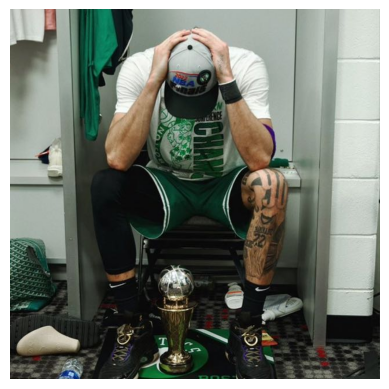

1/1 [==============================] - 0s 149ms/step
Caption: man in black and black shirt and black pants and black pants and black pants and black pants and black pants and black pants and black pants and black pants and black pants


In [33]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload an image
uploaded = files.upload()

for fn in uploaded.keys():
    # Load and preprocess the image
    img_path = fn
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess the image for the model
    img = img.resize((299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    # Extract features
    feature = model_new.predict(x)
    feature = feature.reshape(1, 2048)
    # Generate caption
    caption = generate_caption(model, feature, wordtoix, ixtoword, max_length)
    print('Caption:', caption)


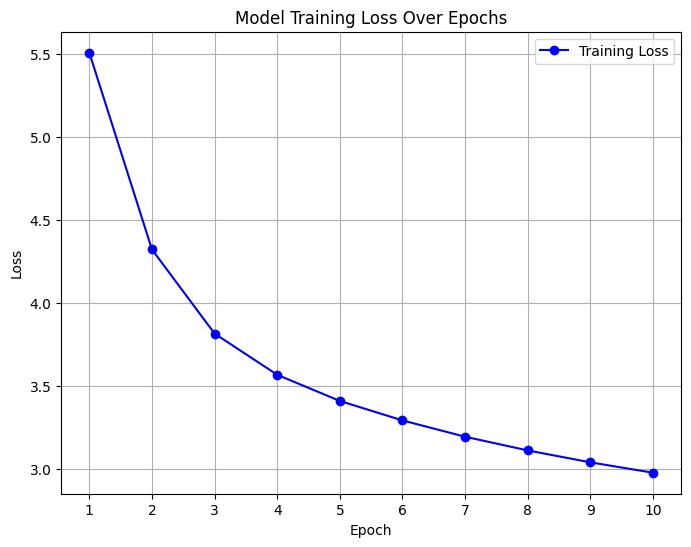

In [34]:
# Loss values from your training logs
loss_values = [5.5049, 4.3217, 3.8159, 3.5682, 3.4109, 3.2938, 3.1958, 3.1134, 3.0418, 2.9793]

# Corresponding epoch numbers
epochs = range(1, 11)  # Epochs 1 to 10
import matplotlib.pyplot as plt

# Plot the loss values
plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Training Loss')
plt.title('Model Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.show()


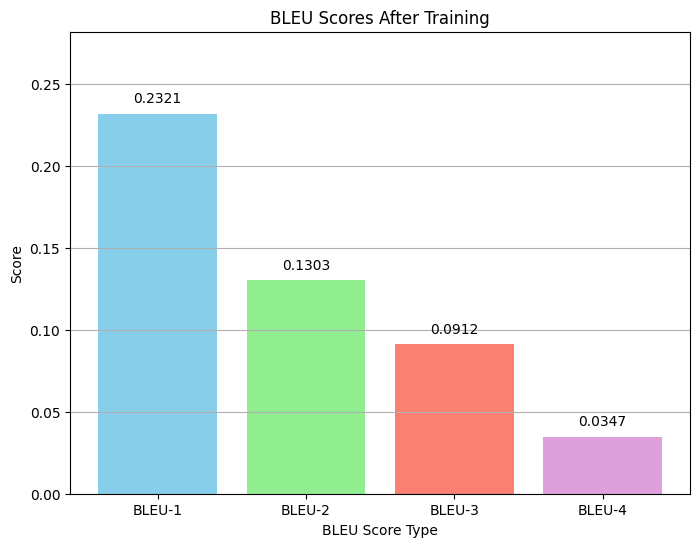

In [35]:
# BLEU scores from your training logs
bleu_scores = {
    'BLEU-1': 0.232092,
    'BLEU-2': 0.130268,
    'BLEU-3': 0.091204,
    'BLEU-4': 0.034691
}

# Separate the keys and values for plotting
bleu_types = list(bleu_scores.keys())
bleu_values = list(bleu_scores.values())
import matplotlib.pyplot as plt

# Plot the BLEU scores as a bar chart
plt.figure(figsize=(8,6))
bars = plt.bar(bleu_types, bleu_values, color=['skyblue', 'lightgreen', 'salmon', 'plum'])

# Add the exact values on top of each bar
for bar, score in zip(bars, bleu_values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{score:.4f}', ha='center', va='bottom')

plt.title('BLEU Scores After Training')
plt.xlabel('BLEU Score Type')
plt.ylabel('Score')
plt.ylim(0, max(bleu_values) + 0.05)  # Adjust y-axis limit for better visibility
plt.grid(axis='y')
plt.show()
